# Compute Average Distance Between Real Location and Perturbated One

In [1]:
import os
import pandas as pd
from sqlalchemy import create_engine
import dotenv
from sqlalchemy.orm import sessionmaker
from sqlalchemy import text
from itertools import product
import numpy as np
import matplotlib.pyplot as plt

Connect to DB if there's not a saved CSV.

In [2]:
CSV_NAME = os.path.join('csvs', f'average_distances.csv')
df = None
if os.path.exists(CSV_NAME):
    df = pd.read_csv(CSV_NAME, index_col=0)
else:
    dotenv.load_dotenv('.env')
    engine = create_engine('postgresql://{0}:{1}@{2}/{3}'.format(
        os.environ.get("TYPEORM_USERNAME"),
        os.environ.get("TYPEORM_PASSWORD"),
        os.environ.get("TYPEORM_HOST"),
        os.environ.get("TYPEORM_DATABASE")), echo=False)

Compute and run the query (takes about 1.5 hours).

Get real positions, perturbated only, dummy only and perturbated&dummy samples.

For each table, compute the distance between real and fake position based on timestamp and, at the end, compute the average between distances per timestamp.

In [3]:
if df is None:
    Session = sessionmaker(bind=engine)
    session = Session()

    perDecimals = [1, 2, 3, 4, 5]
    dumUpRadMin = [0.0007, 0.0006, 0.0005, 0.0004, 0.0003]
    dumUpRadMax = [0.002, 0.003, 0.004, 0.005, 0.006]

    def create_query(table_prefix: str, r_min='-1', r_max='-1', p_dec='-1'):
        return f'''SELECT
                '{r_min!='-1'}' AS "dummyLocation"
                , '{p_dec!='-1'}' as "gpsPerturbated"
                , '{r_min}' as "dumRadMin"
                , '{r_max}' as "dumRadMax"
                , '{p_dec}' as "pertDec"
                , AVG(ST_Distance(p.location, r.location)) / 1000 as avg
            FROM
                project.{table_prefix}_noise p
                , project.real_noise r
            WHERE r.id = p.real_id
        '''

    def replace(num): return str(num).replace('.', '')

    pert_queries = [create_query(f'perturbated{dec}', p_dec=dec) for dec in perDecimals]
    dummy_queries = [create_query(f"dummy{replace(min)}_{replace(max)}", r_min=min, r_max=max)
                     for min, max in product(dumUpRadMin, dumUpRadMax)]
    dummy_pert_queries = [
        create_query(
            f"dummy_pert{replace(min)}_{replace(max)}_{dec}", r_min=min, r_max=max, p_dec=dec)
        for min, max, dec in product(dumUpRadMin, dumUpRadMax, perDecimals)]

    query = '\r\nUNION ALL\r\n'.join([*pert_queries, *dummy_queries, *dummy_pert_queries])
    # print(query)
    res = session.execute(text(query))
    session.close()

Insert query result in dataframe, replace '-1' with 'NaN' and boolean strings in actual booleans.

Lastly, save the dataframe in CSV and show it.

In [4]:
if df is None:
  df = pd.DataFrame(res.fetchall(), columns=res.keys())
df = df.replace({'dumRadMin': -1, 'dumRadMax': -1, 'pertDec': -1}, np.NaN)
# Pandas does not recognize 'True' and 'False' as booleans
df = df.replace({'True': True, 'False': False})

if not os.path.exists('csvs'):
    os.makedirs('csvs')

df.to_csv(CSV_NAME)
df.sort_values(['dummyLocation', 'gpsPerturbated', 'dumRadMin', 'dumRadMax', 'pertDec'])

,dummyLocation,gpsPerturbated,dumRadMin,dumRadMax,pertDec,avg
0,False,True,NaN,NaN,1.0,8.447834
20,False,True,NaN,NaN,2.0,1.082823
19,False,True,NaN,NaN,3.0,0.118612
17,False,True,NaN,NaN,4.0,0.011576
16,False,True,NaN,NaN,5.0,0.001321
...,...,...,...,...,...,...
57,True,True,0.0007,0.006,1.0,21.469553
58,True,True,0.0007,0.006,2.0,2.374650
61,True,True,0.0007,0.006,3.0,0.248520
60,True,True,0.0007,0.006,4.0,0.024760


Plot distances based on configuration.

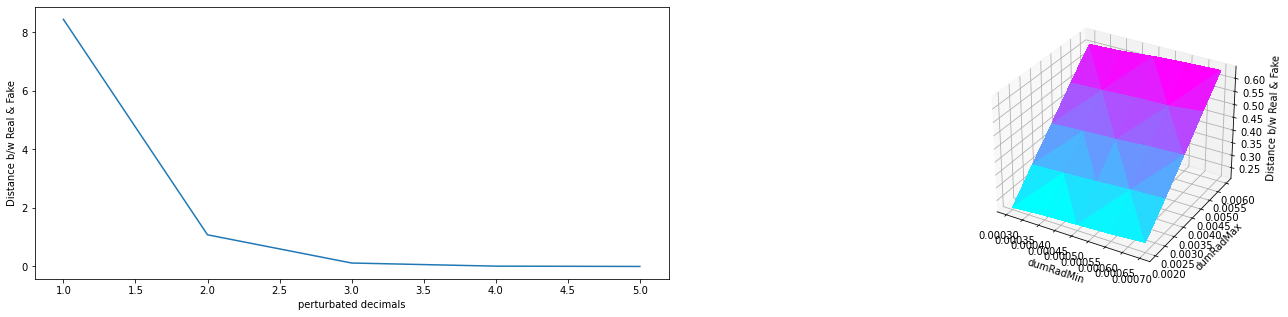

,dumRadMin,dumRadMax,pertDec,avg
90,0.0006,0.003,5.0,0.002918
73,0.0004,0.006,5.0,0.003010
86,0.0007,0.004,5.0,0.003028
38,0.0005,0.005,5.0,0.003078
41,0.0005,0.003,5.0,0.003162
...,...,...,...,...
34,0.0007,0.002,1.0,21.642556
39,0.0007,0.003,1.0,21.646827
104,0.0005,0.005,1.0,21.671348
125,0.0004,0.004,1.0,21.683813


In [5]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [25, 5]

fig = plt.figure()

# First subplot
ax = fig.add_subplot(1, 2, 1)

pertOnly = df[(df['gpsPerturbated'] == True) & (df['dummyLocation'] == False)][['pertDec', 'avg']].sort_values('pertDec')
dummyOnly = df[(df['gpsPerturbated'] == False) & (df['dummyLocation'] == True)][['dumRadMin', 'dumRadMax', 'avg']].sort_values(['dumRadMin', 'dumRadMax'])

ax.plot(pertOnly['pertDec'], pertOnly['avg'])
ax.set_xlabel('perturbated decimals')
ax.set_ylabel('Distance b/w Real & Fake')

# Second subplot
ax = fig.add_subplot(1, 2, 2, projection='3d')

ax.plot_trisurf(
    dummyOnly['dumRadMin'],
    dummyOnly['dumRadMax'],
    dummyOnly['avg'],
    cmap=plt.get_cmap('cool'),
    edgecolor='grey',
    linewidth=0, antialiased=False)
ax.set_xlabel('dumRadMin')
ax.set_ylabel('dumRadMax')
ax.set_zlabel('Distance b/w Real & Fake')
plt.show()

# pd.set_option("max_row", 1000)
# pd.reset_option('max_row')
df[(df['gpsPerturbated'] == True) & (df['dummyLocation'] == True)][['dumRadMin','dumRadMax','pertDec','avg']].sort_values('avg')
